# Hierarchical A* path finding algorithm

Created by - Sanjana Tule

Date - 19/08/2021


* **Implement weighted risk factor**. 

Give higher weightage to risk factors compared to length. As length = 10 and risk = 2 vs length = 2 and risk = 10 should not be the same.
Weighted Risk Factor = Length + 2 * ( Building Density Risk + Distance Risk)

* **Algorithm steps/description**:

Inspired and based on ideas in the paper - https://www.researchgate.net/publication/228785110_Near_optimal_hierarchical_path-finding_HPA

Hierarchical A* algorithm are sub-optimal compared to A* but they are faster. In life threatning situations they would be most suitable than traditional A* as A* finds the complete path before returning the navigation to the user. Compared to that Hierarchical A* only returns abstract navigation path and can calculate the subpaths in parallel while the user is navigating.

Assumptions:
1.   All Street are 2 way as for earthquake people would be walking or even one-way signs can be ignored for safety purposes
2.   For implemenation simplicity only 1 entrance/exit pair between clusters are considered. But in reality we may need to store all of them as the in-flight risk might change as people navigate.

**PART 1 - Pre-processing steps to create abstract graph**
Implemented seperately and graph stored on disk

**PART 2 - Run-time steps ( search for path)**:

1.   Select the source s and destination d.
2.   Find the closest node from abstract graph a_s to s.
3.   Find the closest node from abstract graph d_s to d.
4.   Find the path betwen s and a_s in the original underlying detailed graph.
5.   Find the path betwen d and a_d in the original underlying detailed graph.
6.   Find the path between a_s and a_d in abstract graph.
7.   Plot all the paths together.


**PART 2 - FIND PATH USING ABSTRACT GRAPH**

In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [62]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import math
import time
import warnings
warnings.filterwarnings("ignore")

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PART 2 - PATH FINDING USING ABSTRACT AND DETAILED GRAPH

In [63]:
# Load abstract and detailed graph
graph_detailed = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
graph_abstract = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/3_abstract_graph.pickle')

In [64]:
 ##################################### PART 2 - FIND THE ROUTE #################################################################
 ###############################################################################################################################
# custom plot route function
def plot_route(complete_path,graph_abstract,graph_detailed):

  abstract_intra_nodes_,abstract_edges_ = ox.graph_to_gdfs(graph_abstract)
  detailed_nodes_,edges_nr_all = ox.graph_to_gdfs(graph_detailed)

  complete_path_df = pd.DataFrame()
  for ind,se in enumerate(complete_path):
    if ind != len(complete_path)-1:
      try:
        complete_path_df = complete_path_df.append(abstract_edges_.loc[(se,complete_path[ind+1],0)])
      except:
        complete_path_df = complete_path_df.append(edges_nr_all.loc[(se,complete_path[ind+1],0)])

  complete_path_df_ = geopandas.GeoDataFrame(complete_path_df,geometry='geometry')

  # plot Hieararchical A* path
  fig, ax = plt.subplots(figsize=(20,20))
  ax.set_title('Visualise the Path using Hierarchical A* Algorithm')
  edges_nr_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')
  complete_path_df_.plot(ax=ax, linewidth=3, edgecolor='Red')

# find the distance to the nearest node
def find_close_node_in_abstract_graph(graph_abstract,source_node,graph_detailed):

  nodes_nr_all = ox.graph_to_gdfs(graph_detailed,edges=False)
  detailed_source_point = (nodes_nr_all.loc[(source_node)].y , nodes_nr_all.loc[(source_node)].x)
  abstract_intra_nodes = ox.graph_to_gdfs(graph_abstract,edges=False)

  euc_distance_nearest_node_abstract_graph = abstract_intra_nodes.geometry.apply(lambda x: get_euclidean_distance(detailed_source_point[1],detailed_source_point[0],x))

  return euc_distance_nearest_node_abstract_graph.sort_values().index.values[0]

# euclidea distance
def get_euclidean_distance(s_x,s_y,geom):
    return ox.distance.euclidean_dist_vec(s_y,s_x,geom.bounds[1],geom.bounds[0])

# nearest park
def find_nearest_park_shelter(graph_detailed,source_point,type):
  nodes_park,_ = ox.graph_to_gdfs(graph_detailed)
  nodes_park = nodes_park[nodes_park['evacuation_type']== type]
  
  euc_distance_parks = nodes_park.geometry.apply(lambda x: get_euclidean_distance(source_point[0],source_point[1],x))
  return euc_distance_parks.sort_values().index.values[0]
  
# find shortest route
def find_route(source_address,destination_address,choice_of_destination,graph_detailed,graph_abstract):
  
  # record time
  start_time = time.time()

  # find the nearest source node to the address
  geolocator = Nominatim(user_agent="Nominatim")
  #source_latlon = geolocator.geocode("19130 Tulsa St, Northridge, CA 91326")
  source_latlon = geolocator.geocode(source_address)
  source_point = (source_latlon.latitude, source_latlon.longitude)
  print("source_address_point",source_point)

  # find nearest node to the address in the detailed graph
  source_node, source_dist = ox.get_nearest_node(graph_detailed,source_point,return_dist=True)
  print('source node in detailed graph',source_node)

  # find the nearest node in the abstract graph
  source_abs_graph_node = find_close_node_in_abstract_graph(graph_abstract,source_node,graph_detailed)
  print('source node in abstract graph',source_abs_graph_node)

  # find the shortest path between source node in detailed graph to source node in the abstract graph
  shortest_path_source_to_source_abs = nx.astar_path(G=graph_detailed,source=source_node, target=source_abs_graph_node, heuristic = None, weight='combined_risk')
  print("FIRST HALF - Source Address to Source Node in Abstract Graph",shortest_path_source_to_source_abs)

  # find the destination if not given
  if choice_of_destination == 1: # park
    dest_node = find_nearest_park_shelter(graph_detailed,source_point,'park')
    print('Destination node in detailed graph',dest_node)
  elif choice_of_destination == 2: # shelter
    dest_node = find_nearest_park_shelter(graph_detailed,source_point,'shelter')
    print('Destination node in detailed graph',dest_node)
  else:
    # find the nearest source node to the address
    dest_latlon = geolocator.geocode(destination_address)
    dest_point = (dest_latlon.latitude, dest_latlon.longitude)
    # find nearest node to the address in the detailed graph
    dest_node, dest_dist = ox.get_nearest_node(graph_detailed,dest_point,return_dist=True)
    print('Destination node in detailed graph',dest_node)

  # find the nearest node in the abstract graph
  dest_abs_graph_node = find_close_node_in_abstract_graph(graph_abstract,dest_node,graph_detailed)
  print('destination node in abstract graph',dest_abs_graph_node) 

  # find the middle path in the abstract path
  shortest_path_abs = nx.astar_path(G = graph_abstract, source=source_abs_graph_node, target=dest_abs_graph_node, heuristic = None, weight='combined_risk')
  print("MIDDLE ROUTE - Source to Destination Node in Abstract Graph",shortest_path_abs)

  # find the shortest path betwen destination node in detailed graph to the destination node in the abstract graph
  shortest_path_dest_to_dest_abs = nx.astar_path(G =graph_detailed,source=dest_abs_graph_node, target=dest_node, heuristic = None, weight='combined_risk')
  print("SECOND HALF - Destination Address to Destination Node in Abstract Graph",shortest_path_dest_to_dest_abs)

  if len(shortest_path_abs) == 1:
    shortest_path_source_to_source_abs = shortest_path_source_to_source_abs[1:-1]

  # Join the Shortest Route together
  complete_path  = shortest_path_source_to_source_abs  + shortest_path_abs[1:-1] + shortest_path_dest_to_dest_abs
  print('COMPLETE ROUTE -',complete_path)

  A_time = (time.time() - start_time)
  print("TOTAL TIME",A_time)

  # Plot route
  plot_route(complete_path,graph_abstract,graph_detailed)

  # length and risk
  total_length = sum(nx.Graph(graph_detailed)[u][v].get('length') for u, v in zip(shortest_path_source_to_source_abs[:-1], shortest_path_source_to_source_abs[1:]))
  total_risk = sum(nx.Graph(graph_detailed)[u][v].get('combined_risk') for u, v in zip(shortest_path_source_to_source_abs[:-1], shortest_path_source_to_source_abs[1:]))
  total_length = total_length + sum(nx.Graph(graph_abstract)[u][v].get('length') for u, v in zip(shortest_path_abs[:-1], shortest_path_abs[1:]))
  total_risk = total_risk + sum(nx.Graph(graph_abstract)[u][v].get('combined_risk') for u, v in zip(shortest_path_abs[:-1], shortest_path_abs[1:]))
  total_length = total_length + sum(nx.Graph(graph_detailed)[u][v].get('length') for u, v in zip(shortest_path_dest_to_dest_abs[:-1], shortest_path_dest_to_dest_abs[1:]))
  total_risk = total_risk + sum(nx.Graph(graph_detailed)[u][v].get('combined_risk') for u, v in zip(shortest_path_dest_to_dest_abs[:-1], shortest_path_dest_to_dest_abs[1:]))

  # total length and risk
  print("LENGTH OF THE ROUTE",total_length)
  print("RISK OF THE ROUTE",total_risk)

DEMO 1 - 
FIND PATH FOR CUSTOM DESTINATION

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
source_address_point (34.268061477640316, -118.55029582917044)
source node in detailed graph 122698946
source node in abstract graph 7159751453
FIRST HALF - Source Address to Source Node in Abstract Graph [122698946, 122960457, 122964431, 122964433, 122946508, 122964435, 4036602793, 6658019158, 4036602791, 4036601683, 4036601671, 7241989529, 4036601667, 5665339571, 4036601663, 123541344, 7241989439, 7159751453]
Destination node in detailed graph 7173953826
destination node in abstract graph 123071958
MIDDLE ROUTE - Source to Destination Node in Abstract Graph [7159751453, 6654203173, 6028589506, 7257529019, 6432919600, 123071958]
SECOND HALF - Destination Address to Destination Node in Abstract Graph [123071958, 122846065, 122846067, 122

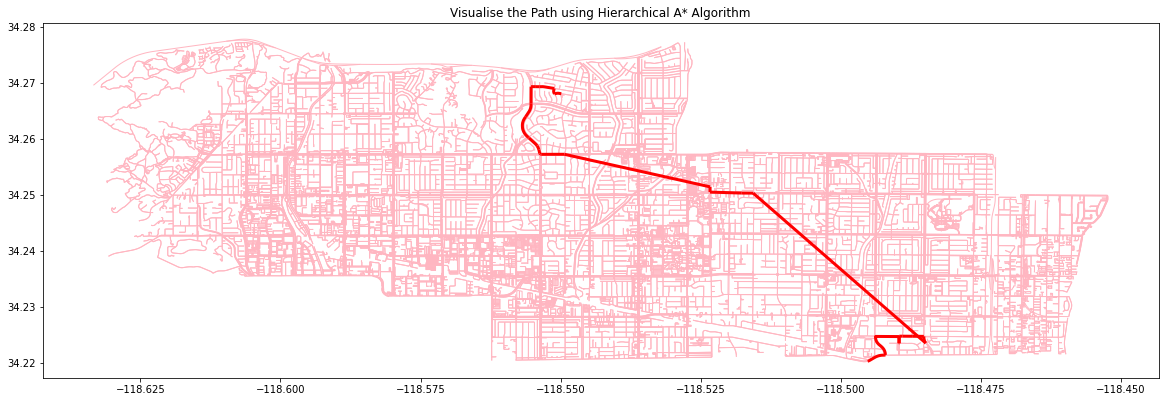

In [65]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

source_address = input('Enter your Current Address.')
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destination_address = input('Please give the Custom Destination Address.')
else:
  destination_address = 'NA'
  
# find shortest route and plot it
find_route(source_address,destination_address,choice_of_destination,graph_detailed,graph_abstract)

# Demo purposes - option 3
# Source Address = 19130 Tulsa St, Northridge, CA 91326
# Destination Address = '7741 Hayvenhurst Ave, Van Nuys, CA 91406'

Enter your Current Address 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.8418 Noble Ave, North Hills, CA 91326
source_address_point (34.274221667539265, -118.62280866492146)
source node in detailed graph 3950442021
source node in abstract graph 123378844
FIRST HALF - Source Address to Source Node in Abstract Graph [3950442021, 5292556391, 123378816, 2857316764, 3950522644, 123378844]
Destination node in detailed graph 122893551
destination node in abstract graph 123507419
MIDDLE ROUTE - Source to Destination Node in Abstract Graph [123378844, 122502372, 6784328049, 364429816, 7241989439, 7159751453, 6654203173, 6028589506, 7257529019, 6432919600, 123071958, 123507419]
SECOND HALF - Destination Address to Destination Node in Abstract Graph [123507419, 123071958, 122846065, 7936630032, 6151532743, 122846063, 122846059, 7927059889, 79270598

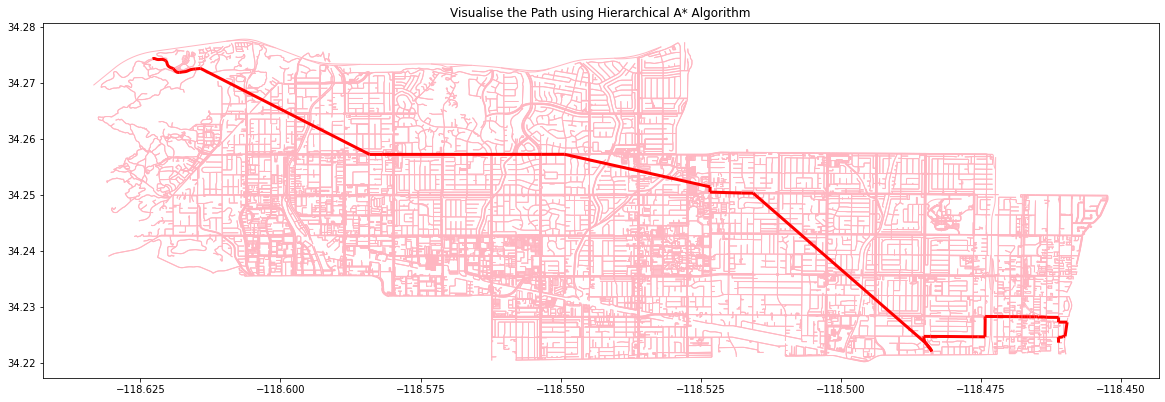

In [66]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

source_address = input('Enter your Current Address ')
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destination_address = input('Please give the Custom Destination Address.')
else:
  destination_address = 'NA'
  
# find shortest route and plot it
find_route(source_address,destination_address,choice_of_destination,graph_detailed,graph_abstract)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 8418 Noble Ave, North Hills, CA 91326

Enter your Current Address  22801 Santa Susana Pass Rd, Chatsworth, CA 91311
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
source_address_point (34.274221667539265, -118.62280866492146)
source node in detailed graph 3950442021
source node in abstract graph 123378844
FIRST HALF - Source Address to Source Node in Abstract Graph [3950442021, 5292556391, 123378816, 2857316764, 3950522644, 123378844]
Destination node in detailed graph 7173953826
destination node in abstract graph 123071958
MIDDLE ROUTE - Source to Destination Node in Abstract Graph [123378844, 122502372, 6784328049, 364429816, 7241989439, 7159751453, 6654203173, 6028589506, 7257529019, 6432919600, 123071958]
SECOND HALF - Destination Address to Destination Node in Abstract Graph [123071958, 122846065, 122846067, 122704808, 122704668, 122704663, 7440172301, 6711058815, 6711058816, 651

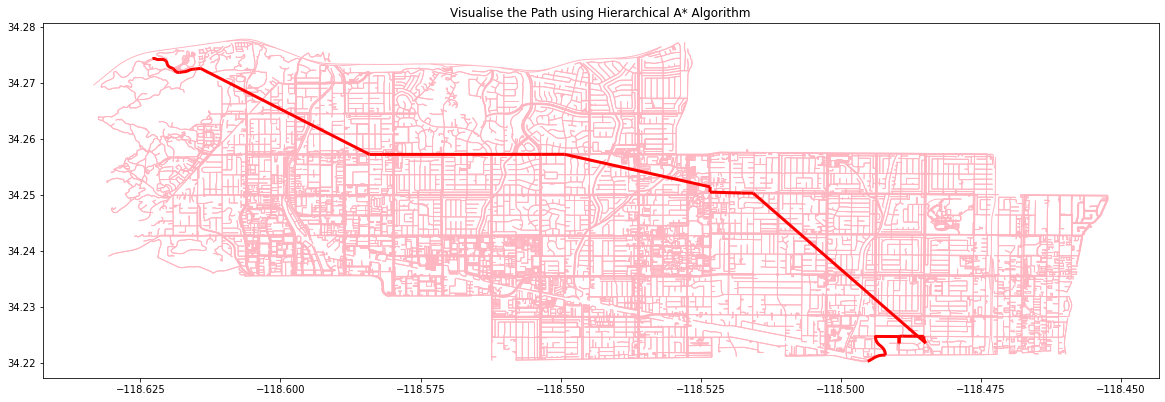

In [67]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

source_address = input('Enter your Current Address ')
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destination_address = input('Please give the Custom Destination Address.')
else:
  destination_address = 'NA'
  
# find shortest route and plot it
find_route(source_address,destination_address,choice_of_destination,graph_detailed,graph_abstract)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

DEMO 2 - 
FIND PATH FOR NEAREST PARK


Enter your Current Address 19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
1
source_address_point (34.268061477640316, -118.55029582917044)
source node in detailed graph 122698946
source node in abstract graph 7159751453
FIRST HALF - Source Address to Source Node in Abstract Graph [122698946, 122960457, 122964431, 122964433, 122946508, 122964435, 4036602793, 6658019158, 4036602791, 4036601683, 4036601671, 7241989529, 4036601667, 5665339571, 4036601663, 123541344, 7241989439, 7159751453]
Destination node in detailed graph 4489631571
destination node in abstract graph 123507419
MIDDLE ROUTE - Source to Destination Node in Abstract Graph [7159751453, 6654203173, 6028589506, 7257529019, 6432919600, 123071958, 123507419]
SECOND HALF - Destination Address to Destination Node in Abstract Graph [123507419, 123071958, 122846065, 7936630032, 6151532743, 122846063, 122846059, 7927059889, 7927059890, 122650

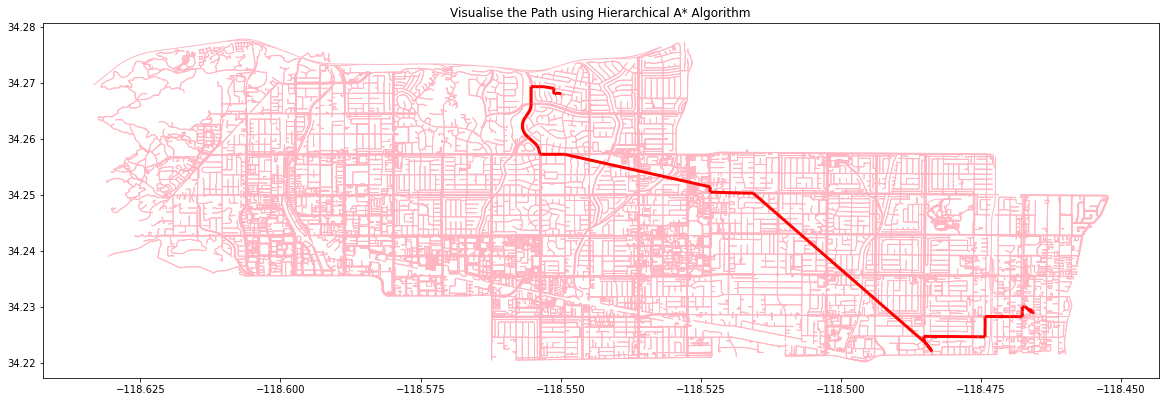

In [68]:
###### MAIN FUNCTION - NEAREST PARK #####

source_address = input('Enter your Current Address ')
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destination_address = input('Please give the Custom Destination Address.')
else:
  destination_address = 'NA'
  
# find shortest route and plot it
find_route(source_address,destination_address,choice_of_destination,graph_detailed,graph_abstract)


DEMO 3 - 
FIND PATH FOR NEAREST SHELTER

Enter your Current Address 19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
2
source_address_point (34.268061477640316, -118.55029582917044)
source node in detailed graph 122698946
source node in abstract graph 7159751453
FIRST HALF - Source Address to Source Node in Abstract Graph [122698946, 122960457, 122964431, 122964433, 122946508, 122964435, 4036602793, 6658019158, 4036602791, 4036601683, 4036601671, 7241989529, 4036601667, 5665339571, 4036601663, 123541344, 7241989439, 7159751453]
Destination node in detailed graph 4622737603
destination node in abstract graph 123680601
MIDDLE ROUTE - Source to Destination Node in Abstract Graph [7159751453, 8239124550, 7920113441, 7241306858, 7241306857, 123145547, 123680601]
SECOND HALF - Destination Address to Destination Node in Abstract Graph [123680601, 652289999, 6670681098, 123117891, 6670681094, 4483110377, 122650333, 5072339686, 6672812942, 12268

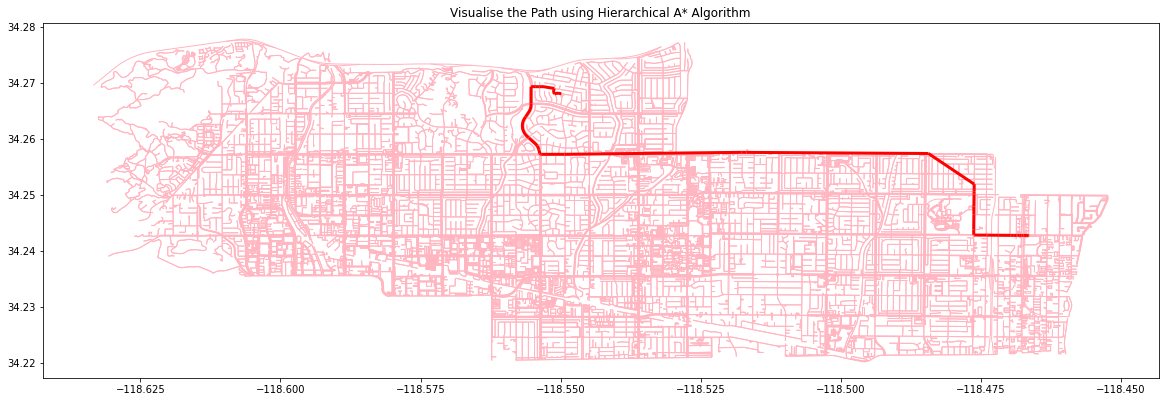

In [69]:
###### MAIN FUNCTION - NEAREST SHELTER #####

source_address = input('Enter your Current Address ')
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destination_address = input('Please give the Custom Destination Address.')
else:
  destination_address = 'NA'
  
# find shortest route and plot it
find_route(source_address,destination_address,choice_of_destination,graph_detailed,graph_abstract)